<a href="https://colab.research.google.com/github/Jushef/Proyectos-ML-DL/blob/main/Unsupervised%20Learning/Clustering/ClusteringForPairsTrading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pairs Trading: búsqueda de parejas basada en la agrupación

En este proyecto, utilizaremos métodos de agrupación para seleccionar pares para una estrategia de negociación de pares.

## Contenido

* [1. Definición del problema](#0)
* [2. Inicio - Cargar bibliotecas y conjunto de datos](#1)
    * [2.1. Cargar Bibliotecas](#1.1)    
    * [2.2. Cargar el conjunto de datos](#1.2)
* [3. Análisis exploratorio de datos](#2)
    * [3.1. Estadísticas descriptivas](#2.1)    
    * [3.2. Visualización de datos](#2.2)
* [4. Preparación de los datos](#3)
    * [4.1. Limpieza de datos](#3.1)
    * [4.3.Transformación de datos](#3.2)  
* [5.Evaluación de algoritmos y modelos](#5)        
    * [5.1. Clustering k-Means](#5.1)
        * [5.1.1 Encontrar el número correcto de clusters](#5.1.1)
        * [5.1.2. Clusterización y visualización](#5.1.2)
    * [5.2. Clustering Jerárquico (Clustering Aglomerativo)](#5.2)
        * [5.2.1. Construcción de un gráfico jerárquico/dendograma](#5.2.1)
        * [5.2.2. Agrupación y visualización](#5.2.1) 
    * [5.3. Clustering de Propagación de Afinidad](#5.3)
        * [5.3.1. Visualización del cluster](#5.2.1)
    * [5.4. Evaluación del cluster](#5.4)        
* [6.Selección de pares](#6)        
    * [6.1. Función de cointegración y selección de pares](#6.1)    
    * [6.2. Visualización de pares](#6.2)     

<a id='0'></a>
# 1. Definición del problema

Nuestro objetivo en este caso de estudio es realizar un análisis de clustering en las acciones del S&P500 y obtener pares para una estrategia de trading de pares.


Los datos de las acciones del S&P 500, obtenidos mediante pandas_datareader de yahoo finance. Incluye datos de precios a partir de 2018.

<a id='1'></a>
# 2. Primeros pasos - Cargar los datos y los paquetes de Python

<a id='1.1'></a>
## 2.1. Carga de los paquetes python

In [5]:
pip install yfinance

     |████████████████████████████████| 63 kB 1.0 MB/s 
     |████████████████████████████████| 6.4 MB 5.3 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import yfinance as yf
import datetime
from pandas_datareader import data as pdr

from sklearn.cluster import KMeans, AgglomerativeClustering,AffinityPropagation, DBSCAN
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold

import matplotlib.ticker as ticker
from itertools import cycle

<a id='1.2'></a>
## 2.2. Cargar los datos

In [7]:
# scraping de wikipedia para obtener la lista de acciones del S&P500
snp500url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
data_table = pd.read_html(snp500url)

In [8]:
tickers = data_table[0][1:]['Symbol'].tolist()
#print(tickers)
print("\nEl número total de empresas es:", len(tickers))


El número total de empresas es: 504


In [10]:
# Obtención de precios de cierre de tickers(500) de google finance, utilizando el paquete DataReader para este propósito
yf.pdr_override()

price_list = []
for ticker in tickers:
    try:
        prices = pdr.get_data_yahoo(ticker, start= datetime.datetime(2018, 1, 1))['Close']
        #print(prices)
        prices = pd.DataFrame(prices)
        prices.columns = [ticker]
        price_list.append(prices)
    except:
        pass
    prices_df = pd.concat(price_list,axis=1)
prices_df.sort_index(inplace=True)

# Una vez descargados los datos se guardan en csv y se extraen los datos del csv 
prices_df.to_csv("SP500Data.csv")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [11]:
# Se importan los datos ya obtenidos de yahoo finance.
dataset = read_csv('/content/SP500Data.csv',index_col=0)

In [12]:
import warnings
warnings.filterwarnings('ignore')

In [13]:
type(dataset)

pandas.core.frame.DataFrame

<a id='2'></a>
# 3. Análisis exploratorio de datos

<a id='2.1'></a>
## 3.1. Estadísticas descriptivas

In [14]:
# shape
dataset.shape

(1056, 504)

In [15]:
# consultar los datos
set_option('display.width', 100)
dataset.head()

,AOS,ABT,ABBV,ABMD,ACN,ATVI,ADM,ADBE,ADP,AAP,...,WMB,WTW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,61.529999,58.790001,98.410004,192.490005,153.839996,64.309998,40.090000,177.699997,115.989998,106.089996,...,31.139999,146.990005,164.300003,47.810001,68.070000,81.599998,103.709999,120.446602,50.700001,NaN
2018-01-03,61.900002,58.919998,99.949997,195.820007,154.550003,65.309998,39.779999,181.039993,117.250000,107.050003,...,32.000000,149.740005,162.520004,47.490002,68.900002,81.529999,105.769997,121.281555,50.639999,NaN
2018-01-04,62.189999,58.820000,99.379997,199.250000,156.380005,64.660004,40.450001,183.220001,118.370003,111.000000,...,32.549999,151.259995,163.399994,47.119999,69.360001,82.360001,107.860001,121.106796,50.849998,NaN
2018-01-05,62.990002,58.990002,101.110001,202.320007,157.669998,66.370003,40.180000,185.339996,118.300003,112.180000,...,32.459999,152.229996,164.490005,46.790001,69.230003,82.839996,109.540001,122.310677,50.869999,NaN
2018-01-08,63.290001,58.820000,99.489998,207.800003,158.929993,66.629997,40.090000,185.039993,117.940002,111.389999,...,32.580002,151.410004,162.300003,47.139999,69.480003,82.980003,110.629997,122.543686,50.619999,NaN


In [16]:
# describir los datos
set_option('precision', 3)
dataset.describe()

,AOS,ABT,ABBV,ABMD,ACN,ATVI,ADM,ADBE,ADP,AAP,...,WMB,WTW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
count,1056.000,1056.000,1056.000,1056.000,1056.000,1056.000,1056.000,1056.000,1056.000,1056.000,...,1056.000,1056.000,1056.000,1056.000,1056.000,1056.000,1056.000,1056.000,1056.000,0.0
mean,56.675,92.208,96.951,287.892,221.578,69.487,48.997,378.329,163.377,162.594,...,24.762,193.498,117.202,60.065,87.142,101.568,294.122,128.804,48.592,NaN
std,11.203,23.017,17.555,69.690,67.152,15.731,10.237,137.160,30.880,33.683,...,3.848,31.339,31.872,8.865,19.729,16.132,148.895,17.565,10.173,NaN
min,34.750,56.270,62.980,130.510,133.670,40.110,29.310,177.700,108.250,75.030,...,9.250,134.840,43.020,42.130,56.640,56.520,103.710,78.282,24.080,NaN
25%,47.328,72.500,84.265,253.345,164.873,55.495,41.955,260.050,139.603,142.222,...,22.130,161.193,91.550,52.305,73.390,88.285,175.672,115.306,43.207,NaN
50%,55.065,86.875,94.440,296.520,196.720,71.315,45.495,332.095,161.110,158.030,...,25.075,196.030,114.345,62.945,79.565,100.290,238.820,125.112,49.665,NaN
75%,65.245,114.723,108.485,333.013,259.522,80.772,56.197,486.105,179.270,177.965,...,27.533,216.655,133.647,67.113,99.600,114.360,415.285,142.449,54.962,NaN
max,85.850,141.460,150.560,449.750,415.420,103.810,84.310,688.370,248.010,241.910,...,33.470,270.070,201.510,74.710,138.030,138.860,614.550,173.408,74.310,NaN


<a id='2.2'></a>
## 3.2. Visualización de datos

Vamos a echar un vistazo detallado a la visualización después de la agrupación.

<a id='3'></a>
## 4. Preparación de datos

<a id='3.1'></a>
## 4.1. Limpieza de datos
Comprobamos los NA en las filas, los eliminamos o los rellenamos con la media de la columna.

In [17]:
# Comprobación de los valores nulos y eliminación de los mismos
print('Null Values =',dataset.isnull().values.any())

Null Values = True


Eliminación de las columnas con más de un 30% de valores perdidos. 

In [18]:
missing_fractions = dataset.isnull().mean().sort_values(ascending=False)

missing_fractions.head(10)

drop_list = sorted(list(missing_fractions[missing_fractions > 0.3].index))

dataset.drop(labels=drop_list, axis=1, inplace=True)
dataset.shape

(1056, 480)

* Dado que hay valores nulos, se elimina la raíz que contiene los valores nulos.

In [19]:
# Rellene los valores que faltan con el último valor disponible en el conjunto de datos. 
dataset=dataset.fillna(method='ffill')
dataset.head()

,AOS,ABT,ABBV,ABMD,ACN,ATVI,ADM,ADBE,ADP,AAP,...,WHR,WMB,WTW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,61.53,58.79,98.41,192.49,153.84,64.31,40.09,177.70,115.99,106.09,...,167.99,31.14,146.99,164.30,47.81,68.07,81.60,103.71,120.447,50.70
2018-01-03,61.90,58.92,99.95,195.82,154.55,65.31,39.78,181.04,117.25,107.05,...,168.84,32.00,149.74,162.52,47.49,68.90,81.53,105.77,121.282,50.64
2018-01-04,62.19,58.82,99.38,199.25,156.38,64.66,40.45,183.22,118.37,111.00,...,168.82,32.55,151.26,163.40,47.12,69.36,82.36,107.86,121.107,50.85
2018-01-05,62.99,58.99,101.11,202.32,157.67,66.37,40.18,185.34,118.30,112.18,...,168.48,32.46,152.23,164.49,46.79,69.23,82.84,109.54,122.311,50.87
2018-01-08,63.29,58.82,99.49,207.80,158.93,66.63,40.09,185.04,117.94,111.39,...,169.05,32.58,151.41,162.30,47.14,69.48,82.98,110.63,122.544,50.62


<a id='3.2'></a>
## 4.2. Transformación de datos

Para la agrupación, utilizaremos los rendimientos anuales y la varianza como variables, ya que son los indicadores del rendimiento de las acciones y su volatilidad. Preparemos las variables de rentabilidad y volatilidad a partir de los datos.

In [20]:
# Calcule la rentabilidad porcentual media anual y las volatilidades en un periodo teórico de un año
returns = dataset.pct_change().mean() * 252
returns = pd.DataFrame(returns)
returns.columns = ['Returns']
returns['Volatility'] = dataset.pct_change().std() * np.sqrt(252)
data=returns
# formatear los datos como una matriz numpy para alimentar el algoritmo K-Means
# data = np.asarray([np.asarray(returns['Returns']),np.asarray(returns['Volatility'])]).T

Todas las variables deben estar en la misma escala antes de aplicar la agrupación, de lo contrario una característica con valores grandes dominará el resultado. Utilizamos StandardScaler en sklearn para estandarizar las características del conjunto de datos en la escala de la unidad (media = 0 y varianza = 1).

In [21]:
from sklearn.preprocessing import StandardScaler 

scaler = StandardScaler().fit(data)
rescaledDataset = pd.DataFrame(scaler.fit_transform(data),columns = data.columns, index = data.index)

# resumir los datos transformados
rescaledDataset.head()
X = rescaledDataset
X.head()

,Returns,Volatility
AOS,-0.726,-0.634
ABT,0.276,-0.908
ABBV,-0.103,-0.640
ABMD,0.327,0.943
ACN,0.366,-0.837


Los parámetros a agrupar son los índices y las variables utilizadas en la agrupación son las columnas. Por lo tanto, los datos están en el formato correcto para ser alimentados a los algoritmos de clustering

<a id='4'></a>
# 5. Evaluar algoritmos y modelos

Vamos a ver los siguientes modelos:

1. __KMeans__
2. __Clustering jerárquico (clustering aglomerativo)__
3. __Propagación de afinidad__

<a id='5.1'></a>
## 5.1. K-Means Clustering


<a id='5.1.1'></a>
### 5.1.1. Encontrar el número óptimo de clusters

En este paso se observan las siguientes métricas:

1. La suma de errores cuadrados (SSE) dentro de los clusters
2. Puntuación de la silueta.

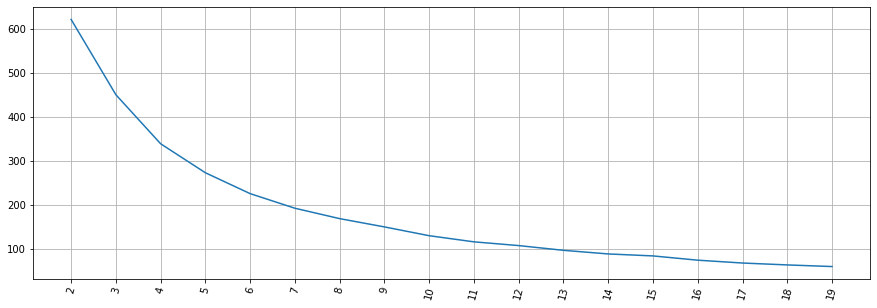

In [22]:
distorsions = []
max_loop=20

for k in range(2, max_loop):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    distorsions.append(kmeans.inertia_)
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, max_loop), distorsions)
plt.xticks([i for i in range(2, max_loop)], rotation=75)
plt.grid(True)

Al inspeccionar el gráfico de la suma de errores al cuadrado, parece que el codo "se dobla" en 5 o 6 grupos para estos datos. Ciertamente, podemos ver que a medida que el número de conglomerados pasa de 6, la suma de errores al cuadrado dentro de los conglomerados se estabiliza.

#### Puntuación de la silueta

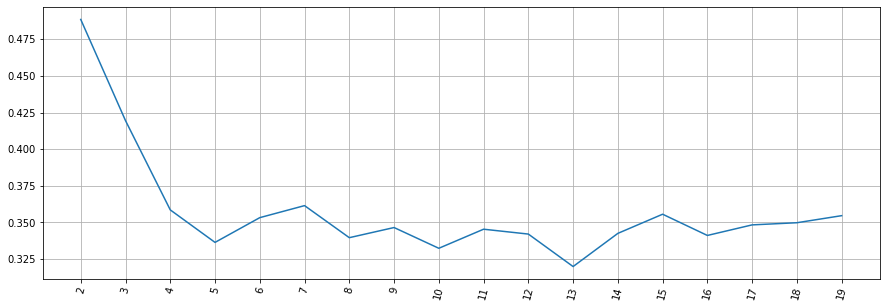

In [24]:
from sklearn import metrics

silhouette_score = []
for k in range(2, max_loop):
        kmeans = KMeans(n_clusters=k,  random_state=10, n_init=10)
        kmeans.fit(X)        
        silhouette_score.append(metrics.silhouette_score(X, kmeans.labels_, random_state=10))
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, max_loop), silhouette_score)
plt.xticks([i for i in range(2, max_loop)], rotation=75)
plt.grid(True)

En el gráfico de puntuación de la silueta, podemos ver que hay varias partes del gráfico en las que se aprecia un pliegue. Dado que no hay mucha diferencia en la SSE después de 6 clusters, preferiríamos 6 clusters en el modelo K-means.

<a id='5.1.2'></a>
### 5.1.2.  Agrupación y visualización

Construyamos el modelo k-means con seis clusters y visualizar los resultados.

In [25]:
nclust = 6

In [26]:
# Ajuste con k-means
k_means = cluster.KMeans(n_clusters=nclust)
k_means.fit(X)

KMeans(n_clusters=6)

In [27]:
# Extracción de etiquetas 
target_labels = k_means.predict(X)

Visualizar cómo se forman los clusters no es una tarea fácil cuando el número de variables/dimensiones de su conjunto de datos es muy grande. Uno de los métodos para visualizar un clúster en un espacio bidimensional.

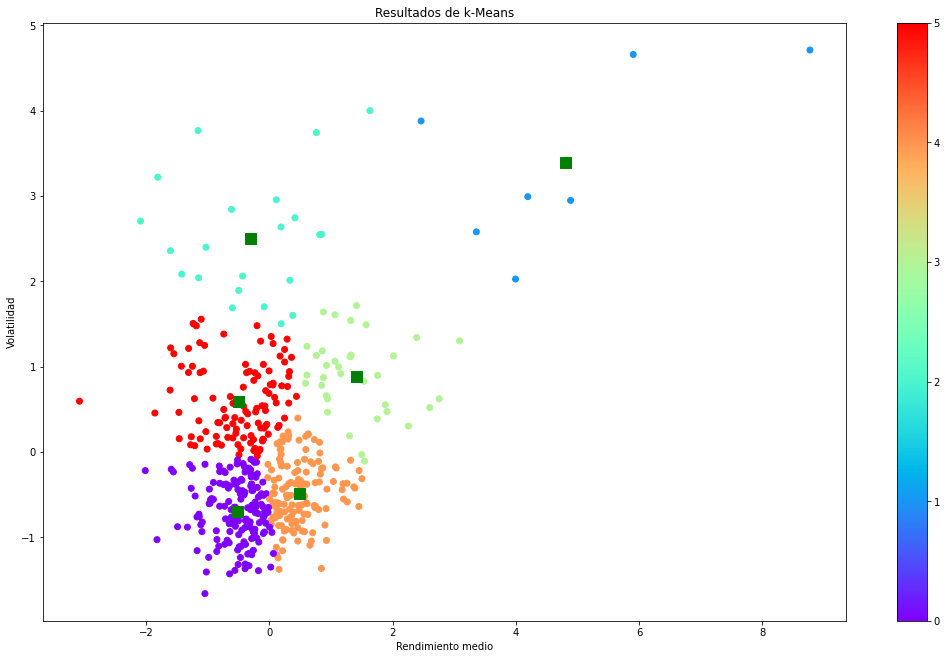

In [28]:
centroids = k_means.cluster_centers_
fig = plt.figure(figsize=(18,11))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0],X.iloc[:,1], c = k_means.labels_, cmap ="rainbow", label = X.index)
ax.set_title('Resultados de k-Means')
ax.set_xlabel('Rendimiento medio')
ax.set_ylabel('Volatilidad')
plt.colorbar(scatter)

plt.plot(centroids[:,0],centroids[:,1],'sg',markersize=11)

* Comprobemos los elementos de las agrupaciones

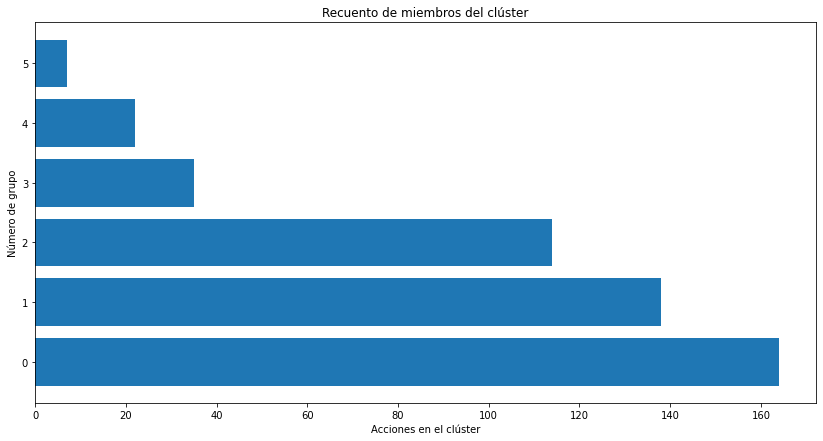

In [29]:
# mostrar el número de existencias en cada grupo
clustered_series = pd.Series(index=X.index, data=k_means.labels_.flatten())

# acciones agrupadas con su etiqueta de agrupación
clustered_series_all = pd.Series(index=X.index, data=k_means.labels_.flatten())
clustered_series = clustered_series[clustered_series != -1]

plt.figure(figsize=(14,7))
plt.barh(
    range(len(clustered_series.value_counts())), # etiquetas de los clusters, eje Y
    clustered_series.value_counts()
)
plt.title('Recuento de miembros del clúster')
plt.xlabel('Acciones en el clúster')
plt.ylabel('Número de grupo')
plt.show()

El número de valores de un grupo oscila entre 20 y 160 aproximadamente. Aunque la distribución no es equitativa, tenemos un número significativo de valores en cada grupo.

<a id='5.2'></a>
## 5.2. Clustering jerárquico (clustering aglomerativo)

En el primer paso miramos el gráfico de la jerarquía y comprobamos el número de clusters

<a id='5.2.1'></a>
### 5.2.1. Construir un gráfico jerárquico / dendograma

La clase jerarquía tiene un método *dendrograma* que toma el valor devuelto por el método *linkage* de la misma clase. El método de vinculación toma como parámetros el conjunto de datos y el método para minimizar las distancias. Utilizamos ***'ward'*** como método ya que minimiza entonces variantes de distancias entre los clusters.

In [30]:
from scipy.cluster.hierarchy import dendrogram, linkage, ward

# Calcular el linkage
Z= linkage(X, method='ward')
Z[0]

array([1.80000000e+01, 3.65000000e+02, 2.54179587e-03, 2.00000000e+00])

La mejor manera de visualizar un algoritmo de aglomeración es mediante un dendograma, que muestra un árbol de clusters, siendo las hojas las poblaciones individuales y la raíz el cluster único final. La "distancia" entre cada conglomerado se muestra en el eje y, por tanto, cuanto más largas sean las ramas, menos correlacionados estarán dos conglomerados.

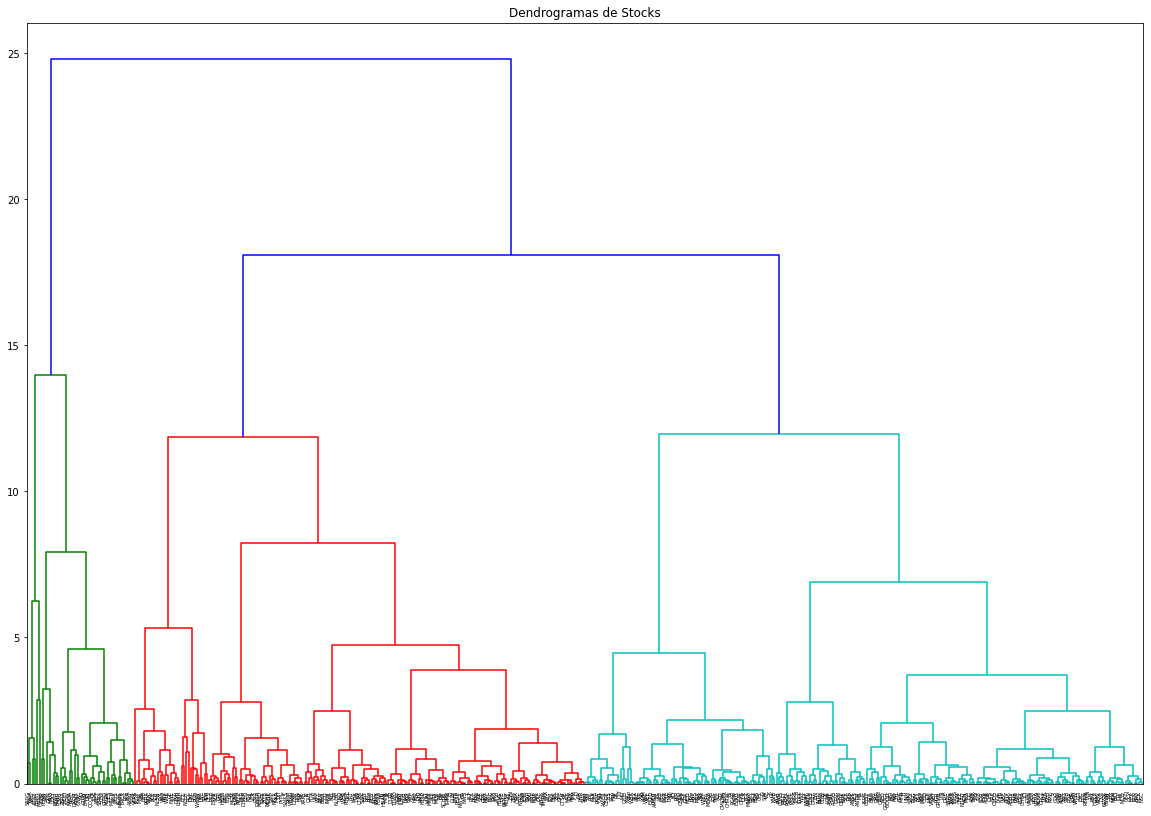

In [33]:
#Plot Dendogram
plt.figure(figsize=(20, 14))
plt.title("Dendrogramas de Stocks")
dendrogram(Z,labels = X.index)
plt.show()

Una vez que se ha formado un gran clúster, se selecciona la distancia vertical más larga sin que pase ninguna línea horizontal y se traza una línea horizontal a través de ella. El número de líneas verticales que pasa esta línea horizontal recién creada es igual al número de clusters.
A continuación, seleccionamos el umbral de distancia para cortar el dendrograma y obtener el nivel de clustering seleccionado. El resultado es el cluster etiquetado para cada fila de datos. Como se esperaba del dendrograma, un corte en 13 nos da cuatro clusters.

In [35]:
distance_threshold = 13
clusters = fcluster(Z, distance_threshold, criterion='distance')
chosen_clusters = pd.DataFrame(data=clusters, columns=['cluster'])
chosen_clusters['cluster'].unique()

array([4, 3, 2, 1], dtype=int32)

<a id='5.2.2'></a>
### 5.2.2.  Agrupación y visualización

In [36]:
nclust = 4
hc = AgglomerativeClustering(n_clusters=nclust, affinity = 'euclidean', linkage = 'ward')
clust_labels1 = hc.fit_predict(X)

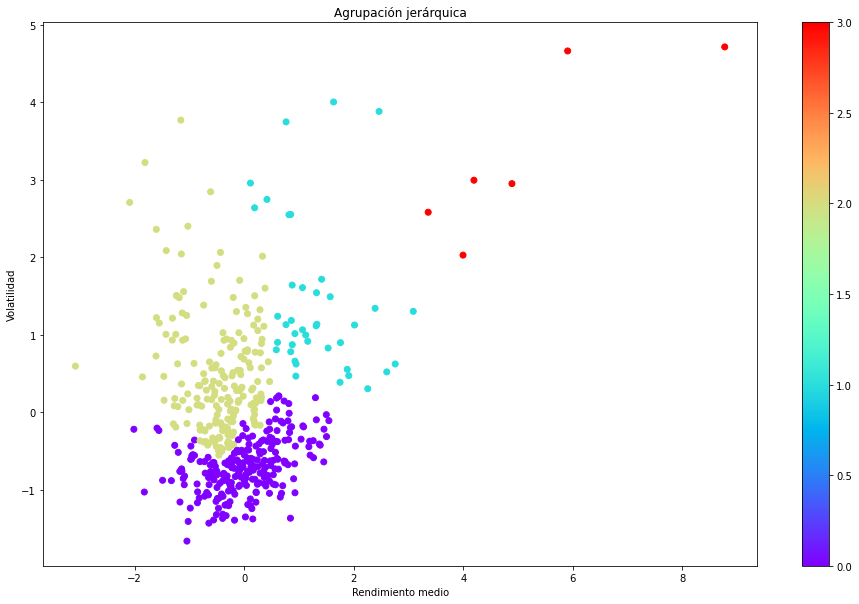

In [37]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0],X.iloc[:,1], c =clust_labels1, cmap ="rainbow")
ax.set_title('Agrupación jerárquica')
ax.set_xlabel('Rendimiento medio')
ax.set_ylabel('Volatilidad')
plt.colorbar(scatter)

Al igual que en el gráfico de la agrupación de k-means, vemos que hay algunos clusters distintos separados por colores diferentes. 

<a id='5.3'></a>
## 5.3. Propagación de afinidad

In [38]:
ap = AffinityPropagation()
ap.fit(X)
clust_labels2 = ap.predict(X)

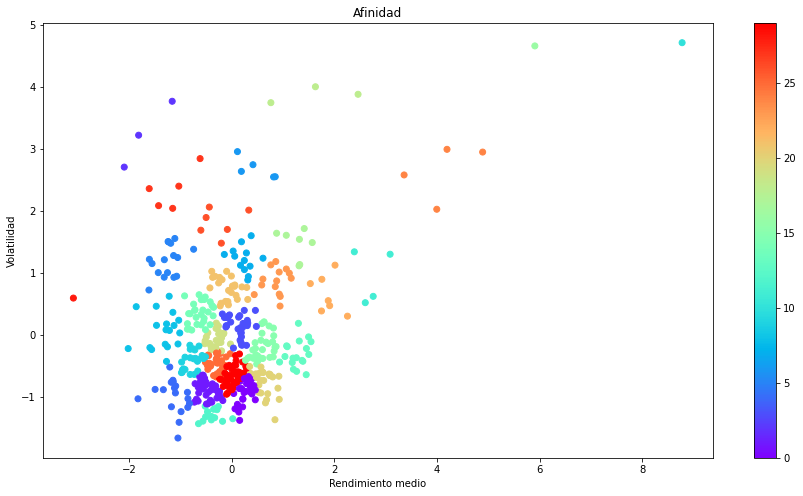

In [40]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0],X.iloc[:,1], c =clust_labels2, cmap ="rainbow")
ax.set_title('Afinidad')
ax.set_xlabel('Rendimiento medio')
ax.set_ylabel('Volatilidad')
plt.colorbar(scatter)

* Al igual que en el gráfico de la agrupación de k-means, vemos que hay algunos clusters distintos separados por colores diferentes. 

<a id='5.3.1'></a>
### 5.3.1 Visualización de clústeres

In [41]:
cluster_centers_indices = ap.cluster_centers_indices_
labels = ap.labels_

Número estimado de clusters: 30


<Figure size 432x288 with 0 Axes>

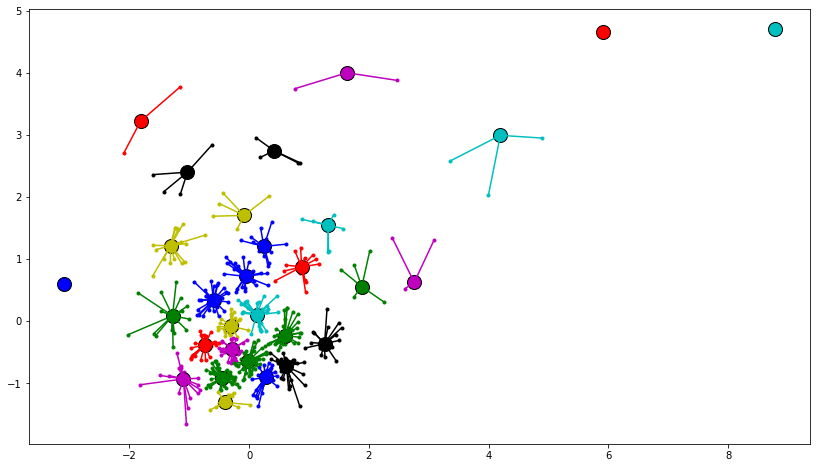

In [42]:
no_clusters = len(cluster_centers_indices)
print('Número estimado de clusters: %d' % no_clusters)
# Plot exemplars

X_temp=np.asarray(X)
plt.close('all')
plt.figure(1)
plt.clf()

fig = plt.figure(figsize=(14,8))
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(no_clusters), colors):
    class_members = labels == k
    cluster_center = X_temp[cluster_centers_indices[k]]
    plt.plot(X_temp[class_members, 0], X_temp[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=14)
    for x in X_temp[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.show()

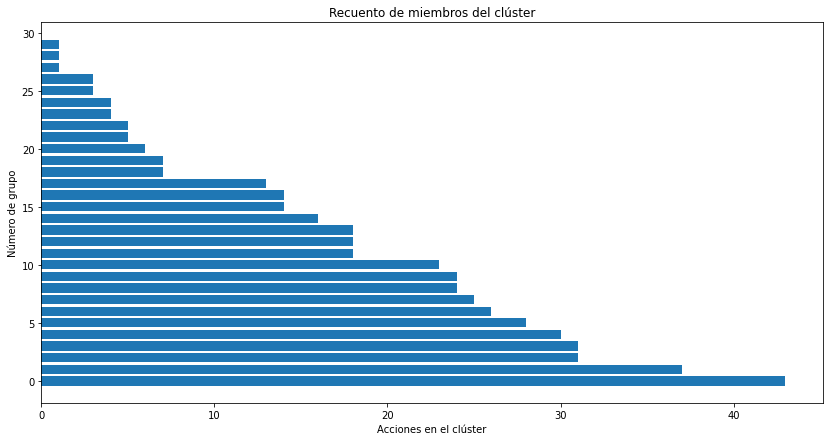

In [43]:
# mostrar el número de existencias en cada grupo
clustered_series_ap = pd.Series(index=X.index, data=ap.labels_.flatten())

# acciones agrupadas con su etiqueta de agrupación
clustered_series_all_ap = pd.Series(index=X.index, data=ap.labels_.flatten())
clustered_series_ap = clustered_series_ap[clustered_series != -1]

plt.figure(figsize=(14,7))
plt.barh(
    range(len(clustered_series_ap.value_counts())), # etiquetas de los clusters, eje Y
    clustered_series_ap.value_counts()
)
plt.title('Recuento de miembros del clúster')
plt.xlabel('Acciones en el clúster')
plt.ylabel('Número de grupo')
plt.show()

<a id='5.4'></a>
## 5.4. Evaluación de la agrupación

Si no se conocen las etiquetas de la verdad sobre el terreno, la evaluación debe realizarse utilizando el propio modelo. El Coeficiente de Silueta (sklearn.metrics.silhouette_score) es un ejemplo de este tipo de evaluación, en el que una mayor puntuación del Coeficiente de Silueta se relaciona con un modelo con clusters mejor definidos. El Coeficiente de Silueta se define para cada muestra y se compone de dos puntuaciones:

In [44]:
from sklearn import metrics
print("km", metrics.silhouette_score(X, k_means.labels_, metric='euclidean'))
print("hc", metrics.silhouette_score(X, hc.fit_predict(X), metric='euclidean'))
print("ap", metrics.silhouette_score(X, ap.labels_, metric='euclidean'))

km 0.35159310515158726
hc 0.30537209766416845
ap 0.3370815527317224


Dado que la propagación por afinidad es la que mejor funciona, seguimos adelante con la propagación por afinidad y utilizamos 30 clusters como se especifica en este método de agrupación

### Visualización del rendimiento dentro de un clúster

Para entender la intuición que hay detrás de la agrupación, visualicemos los resultados de los clusters.

In [45]:
# todas las existencias con su etiqueta de grupo (incluyendo -1)
clustered_series = pd.Series(index=X.index, data=ap.fit_predict(X).flatten())

# acciones agrupadas con su etiqueta de agrupación
clustered_series_all = pd.Series(index=X.index, data=ap.fit_predict(X).flatten())
clustered_series = clustered_series[clustered_series != -1]

In [46]:
# obtener el número de acciones en cada grupo
counts = clustered_series_ap.value_counts()

# visualicemos algunos clusters
cluster_vis_list = list(counts[(counts<25) & (counts>1)].index)[::-1]
cluster_vis_list

[18, 2, 11, 24, 6, 27, 26, 22, 17, 7, 23, 12, 5, 8, 13, 4, 9, 21, 20]

In [47]:
CLUSTER_SIZE_LIMIT = 9999
counts = clustered_series.value_counts()
ticker_count_reduced = counts[(counts>1) & (counts<=CLUSTER_SIZE_LIMIT)]
print ("Agrupaciones formadas: %d" % len(ticker_count_reduced))
print ("Pares para evaluar: %d" % (ticker_count_reduced*(ticker_count_reduced-1)).sum())

Agrupaciones formadas: 27
Pares para evaluar: 11352


In [48]:
# trazar un puñado de las agrupaciones más pequeñas
plt.figure(figsize=(12,7))
cluster_vis_list[0:min(len(cluster_vis_list), 4)]

[18, 2, 11, 24]

<Figure size 864x504 with 0 Axes>

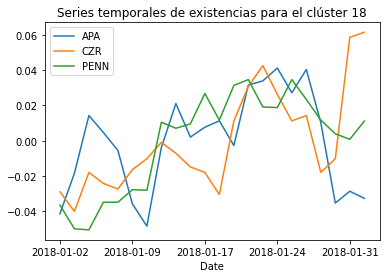

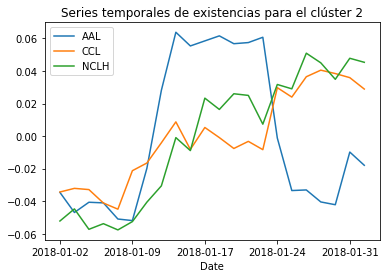

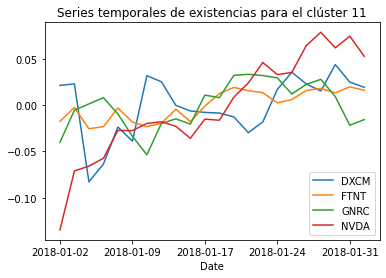

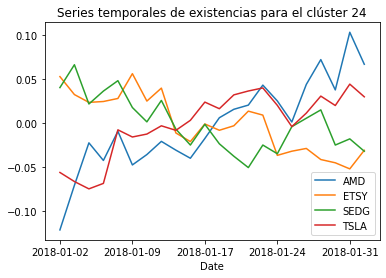

In [49]:
for clust in cluster_vis_list[0:min(len(cluster_vis_list), 4)]:
    tickers = list(clustered_series[clustered_series==clust].index)
    means = np.log(dataset.loc[:"2018-02-01", tickers].mean())
    data = np.log(dataset.loc[:"2018-02-01", tickers]).sub(means)
    data.plot(title='Series temporales de existencias para el clúster %d' % clust)
plt.show()

Si observamos los gráficos anteriores, en todos los grupos con un número reducido de valores, vemos un movimiento similar de los valores en los distintos grupos, lo que corrobora la eficacia de la técnica de agrupación.

<a id='6'></a>
# 6. Selección de parejas

<a id='6.1'></a>
## 6.1. Función de cointegración y selección de pares

In [50]:
def find_cointegrated_pairs(data, significance=0.05):
    # Esta función es de https://www.quantopian.com/lectures/introduction-to-pairs-trading
    n = data.shape[1]    
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(1):
        for j in range(i+1, n):
            S1 = data[keys[i]]            
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < significance:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [52]:
from statsmodels.tsa.stattools import coint

cluster_dict = {}

for i, which_clust in enumerate(ticker_count_reduced.index):
    tickers = clustered_series[clustered_series == which_clust].index   
    score_matrix, pvalue_matrix, pairs = find_cointegrated_pairs(dataset[tickers])
    cluster_dict[which_clust] = {}
    cluster_dict[which_clust]['score_matrix'] = score_matrix
    cluster_dict[which_clust]['pvalue_matrix'] = pvalue_matrix
    cluster_dict[which_clust]['pairs'] = pairs

MissingDataError: ignored

In [53]:
pairs = []
for clust in cluster_dict.keys():
    pairs.extend(cluster_dict[clust]['pairs'])

In [54]:
print ("Número de parejas encontradas : %d" % len(pairs))
print ("En esas parejas, hay %d tickers únicos." % len(np.unique(pairs)))

Número de parejas encontradas : 10
En esas parejas, hay 15 tickers únicos.


In [55]:
pairs

[('ABBV', 'ABC'),
 ('ABBV', 'JBHT'),
 ('APD', 'DLR'),
 ('ADBE', 'BIO'),
 ('ADBE', 'CTLT'),
 ('ADBE', 'DPZ'),
 ('AFL', 'AVB'),
 ('AFL', 'ESS'),
 ('AFL', 'TRV'),
 ('AXP', 'MLM')]

<a id='6.2'></a>
## 6.2. Pair Visualization

In [56]:
from sklearn.manifold import TSNE
import matplotlib.cm as cm
stocks = np.unique(pairs)
X_df = pd.DataFrame(index=X.index, data=X).T

In [57]:
in_pairs_series = clustered_series.loc[stocks]
stocks = list(np.unique(pairs))
X_pairs = X_df.T.loc[stocks]

In [58]:
X_tsne = TSNE(learning_rate=50, perplexity=3, random_state=1337).fit_transform(X_pairs)

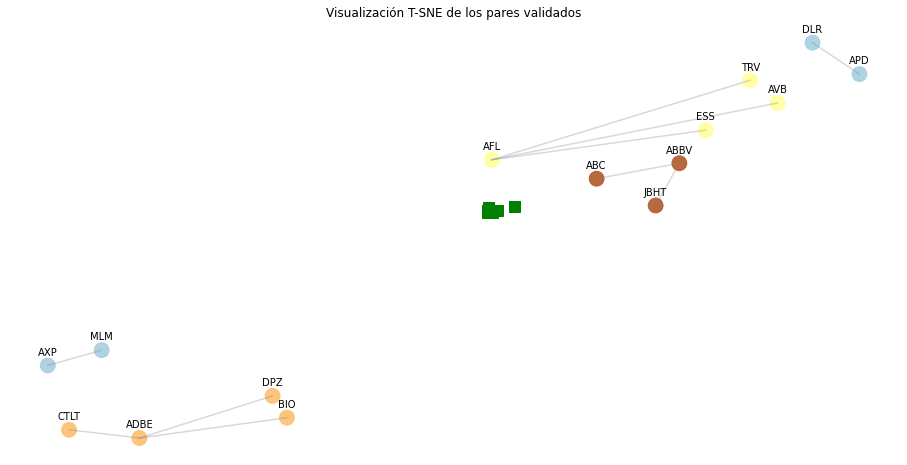

In [59]:
plt.figure(1, facecolor='white',figsize=(16,8))
plt.clf()
plt.axis('off')
for pair in pairs:
    #print(pair[0])
    ticker1 = pair[0]
    loc1 = X_pairs.index.get_loc(pair[0])
    x1, y1 = X_tsne[loc1, :]
    #print(ticker1, loc1)

    ticker2 = pair[0]
    loc2 = X_pairs.index.get_loc(pair[1])
    x2, y2 = X_tsne[loc2, :]
      
    plt.plot([x1, x2], [y1, y2], 'k-', alpha=0.3, c='gray');
    
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=220, alpha=0.9, c=in_pairs_series.values, cmap=cm.Paired)
plt.title('Visualización T-SNE de los pares validados'); 

# zip une las coordenadas x e y en pares
for x,y,name in zip(X_tsne[:,0],X_tsne[:,1],X_pairs.index):

    label = name

    plt.annotate(label, # este es el texto
                 (x,y), # este es el punto a etiquetar
                 textcoords="offset points", # cómo colocar el texto
                 xytext=(0,10), # distancia del texto a los puntos (x,y)
                 ha='center') # la alineación horizontal puede ser a la izquierda, a la derecha o al centro
    
plt.plot(centroids[:,0],centroids[:,1],'sg',markersize=11)


**Conclusión**

Las técnicas de agrupación no ayudan directamente a predecir la tendencia de las acciones. Sin embargo, pueden utilizarse eficazmente en la construcción de carteras para encontrar los pares adecuados, lo que a la larga ayuda a mitigar el riesgo y se puede lograr un rendimiento superior ajustado al riesgo.

Mostramos los enfoques para encontrar el número adecuado de clusters en k-means y construimos un gráfico de jerarquía en la agrupación jerárquica. El siguiente paso de este proyecto sería explorar y realizar pruebas retrospectivas de diversas estrategias de negociación a largo/corto plazo con pares de valores de las agrupaciones de valores.

La agrupación puede utilizarse eficazmente para dividir las acciones en grupos con "características similares" para muchos otros tipos de estrategias de negociación y puede ayudar en la construcción de carteras para garantizar que elegimos un universo de acciones con suficiente diversificación entre ellas.